<a href="https://colab.research.google.com/github/siva-sankar-a/eva/blob/master/S10/EVA4_Session_10_LR_range_finder_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S10 _Assignment 10_

  | Summary of overall targets |  |
  | - | - |
  | _Dataset_| **CIFAR10** |
  | _Max. number of epochs_| **50** |
  | _Max. number of parameters_| **NA** |
  | _Architecture_| **Resnet18** |
  | _Target accurracy_| **88%** |


# Implementation

## Initialization

### Mounting google drive to save results

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install torchsummary
!pip install torchviz
!pip install albumentations
!pip install apex

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 716kB 24.1MB/s 
     |████████████████████████████████| 327kB 53.3MB/s 
     |████████████████████████████████| 174kB 62.0MB/s 
     |████████████████████████████████| 235kB 56.0MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 133kB 57.1MB/s 
     |████████████████████████████████| 122kB 60.0MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
  Created wheel for cryptacular: filename=cryptacular-1.5.5-cp36-abi3-manylinux2010_x86_64.whl size=47561 sha256=5365d7511adb9142e6cdf63615bee3c77ff6347077b933343136a5cda9eefb0e
  Stored in directory: /root/.cache/pip/wheels/3c/79/bc/1eec7120c3ff9b0a2c7ad94d1626abc3388688e2ed7a45878f
Successfully built cryptacular
  Created wheel for apex: filename=apex-0.9.10.dev0-cp36-none-any.whl size=46467 sha256=9de331a11d1226fa24fb09e4e8

In [0]:
import glob
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
import torch
import torchvision
import numpy as np

from torch.nn import functional as F
import cv2

In [0]:
# Pytorch import
import torch
import torch.optim as optim                        # Import optimizer module from pytorch
import torch.nn as nn

In [0]:
!rm -rf eva
!git clone "https://github.com/siva-sankar-a/eva.git"

Cloning into 'eva'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 424 (delta 77), reused 77 (delta 36), pack-reused 291
Receiving objects: 100% (424/424), 4.98 MiB | 7.58 MiB/s, done.
Resolving deltas: 100% (234/234), done.


In [0]:
%load_ext autoreload
%autoreload 2
from eva.S10.api import Experiment
from eva.S10.data_manager.data_manager_albumentations import  DataManager
from eva.S10.viz import viz_cifar10_grid_
from eva.S10.utils import textual_summary_cifar10, graphical_summary_cifar10
from eva.S10.settings import cifar10_classes
from eva.S10.models.model_s9 import ResNet, ResNet18
from eva.S10.grad_cam.grad_cam import GradCam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
from eva.S10.lr_range_finder.lr_finder import LRFinder

### Create an instance of experiment class

In [0]:
experiment = Experiment(name=f'default', dataset_name='cifar10')

CUDA status: True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Current transformations 

```
self.train_transforms = transforms.Compose([
transforms.RandomRotation(15),
transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))])
```

In [0]:
from torchvision import datasets

In [0]:
class CIFAR10_dataset(datasets.CIFAR10):
  """
  Custom class to include albumentations data augmentations
  """

  def __init__(self, **kwargs):
    """
    Constructor for custom CIFAR10 dataset
    """
    super().__init__(**kwargs)
  
  def __getitem__(self, index):
    """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
    img, target = self.data[index], self.targets[index]

    # doing this so that it is consistent with all other datasets
    if self.transform:
      augmented = self.transform(image=img)
      img = augmented['image']

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target

In [0]:
from albumentations import Compose, Rotate, HorizontalFlip, Normalize, RandomSizedCrop, Cutout
from albumentations.pytorch import ToTensor

In [0]:
train_transforms = Compose([
    Rotate(limit=15),
    Cutout(num_holes=4, max_h_size=8, max_w_size=8, always_apply=False, p=0.5),
    # RandomSizedCrop(min_max_height=(20, 32), height=32, width=32),
    HorizontalFlip(),
    Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2471, 0.2435, 0.2616],
    ),
    ToTensor()
])

test_transforms = Compose([
    Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2471, 0.2435, 0.2616],
    ),
    ToTensor()
])

In [0]:
trainset = CIFAR10_dataset(root='./data', train=True, download=True, transform=train_transforms)
testset = CIFAR10_dataset(root='./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
data_manager = DataManager(trainset=trainset, testset=testset)

In [0]:
experiment.data_manager = data_manager

In [0]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [0]:
# get some random training images
dataiter = iter(data_manager.train_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


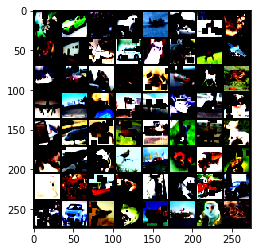

In [0]:
# show images
show(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % cifar10_classes[labels[j]] for j in range(4)))

In [0]:
viz_cifar10_grid(experiment.data_manager.train_loader)

In [0]:
textual_summary_cifar10(experiment.model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

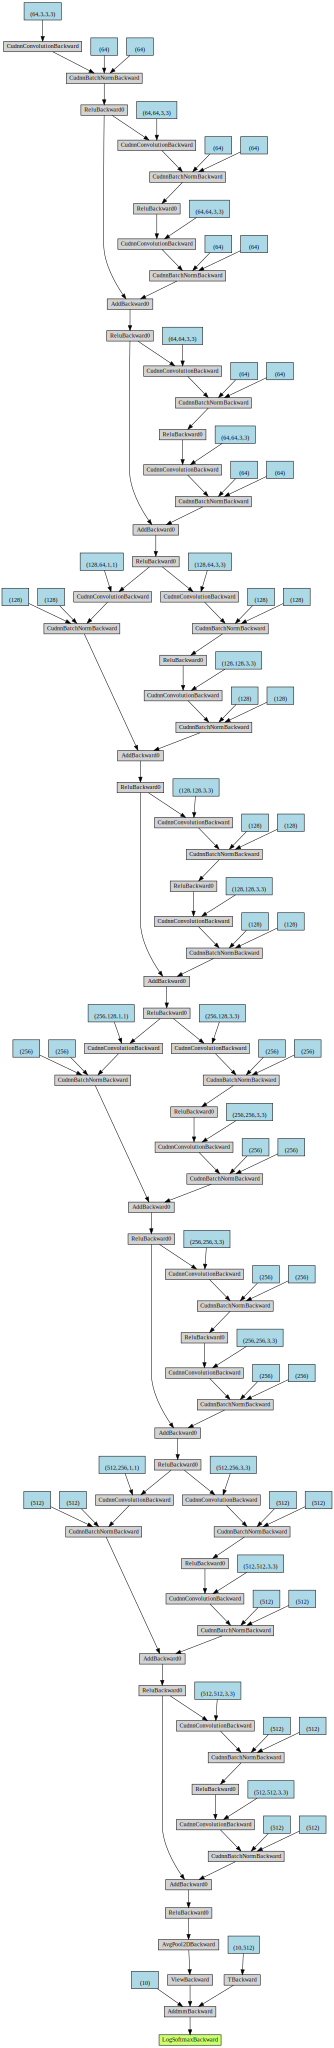

In [0]:
graphical_summary_cifar10(experiment.model)

In [0]:
experiment.run(epochs=2, momentum=0.9, lr=0.01, regularization=None, weight_decay=0.01)

TRAIN : epoch=0 train_loss=0.02439 correct/total=21761/50000 accuracy=43.52: 100%|██████████| 782/782 [00:31<00:00, 24.89it/s]
TEST :  epoch=0 test_loss=1.16824 correct/total=5773/10000 accuracy=57.73: 100%|██████████| 157/157 [00:02<00:00, 54.10it/s]
TRAIN : epoch=1 train_loss=0.01715 correct/total=30624/50000 accuracy=61.25: 100%|██████████| 782/782 [00:31<00:00, 25.11it/s]
TEST :  epoch=1 test_loss=1.45050 correct/total=5642/10000 accuracy=56.42: 100%|██████████| 157/157 [00:02<00:00, 53.49it/s]


In [0]:
experiment.load_summary()

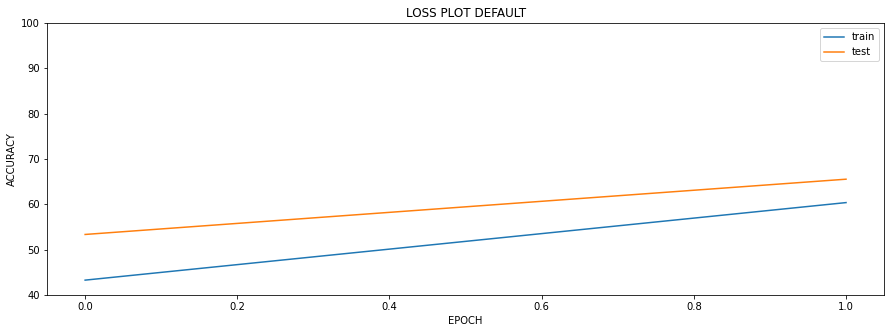

In [0]:
experiment.plot_metric()

In [0]:
mis_classified_images = experiment.get_mis_classified()

In [0]:
target_layers = ['layer1.0.bn2', 'layer1.1.bn2', 'layer2.0.bn2', 'layer2.1.bn2', 'layer3.0.bn2', 'layer3.1.bn2', 'layer4.0.bn2', 'layer4.1.bn2']
grad_cam = GradCam(experiment.model, data_manager=experiment.data_manager, target_layers=target_layers, device=experiment.device)

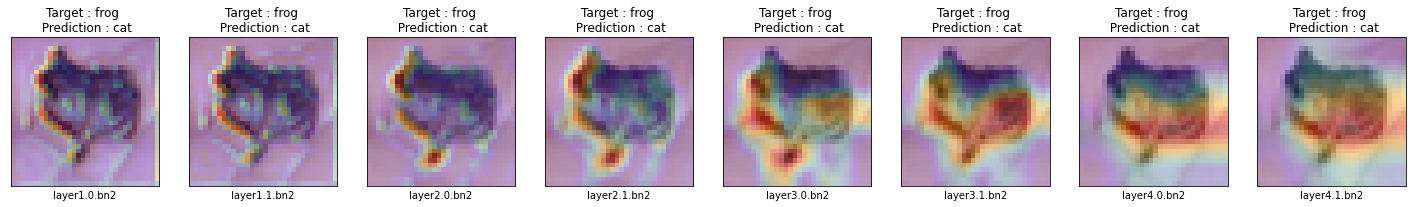

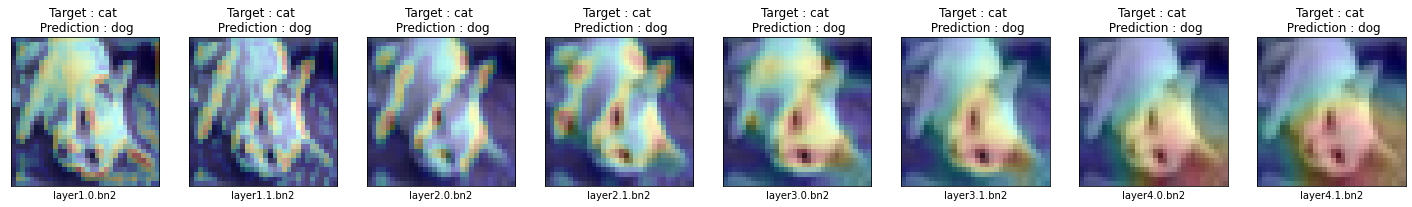

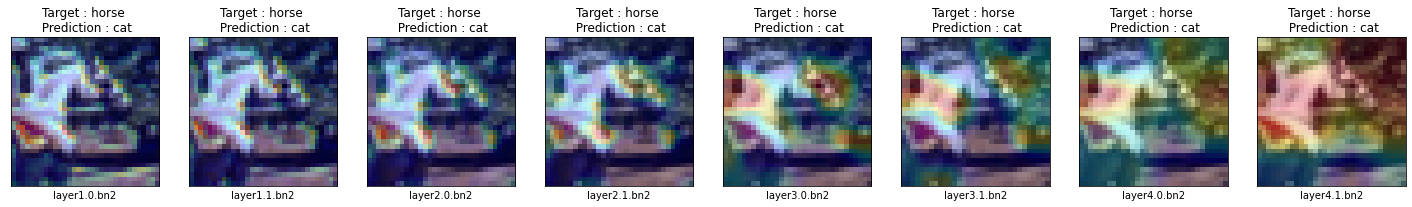

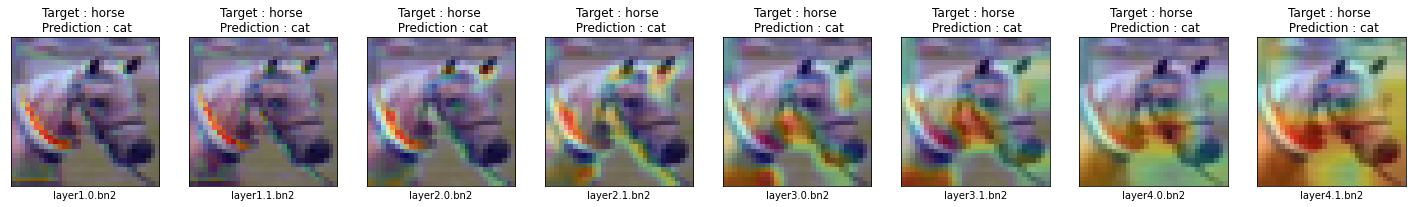

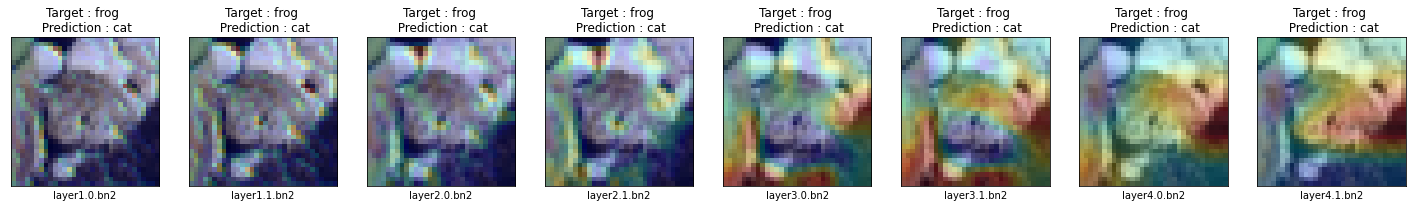

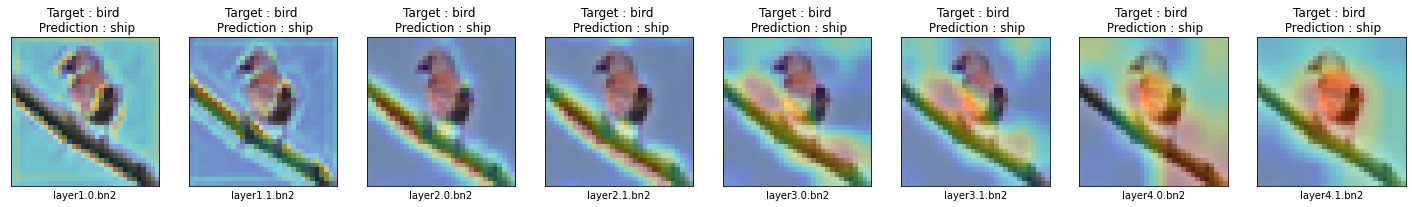

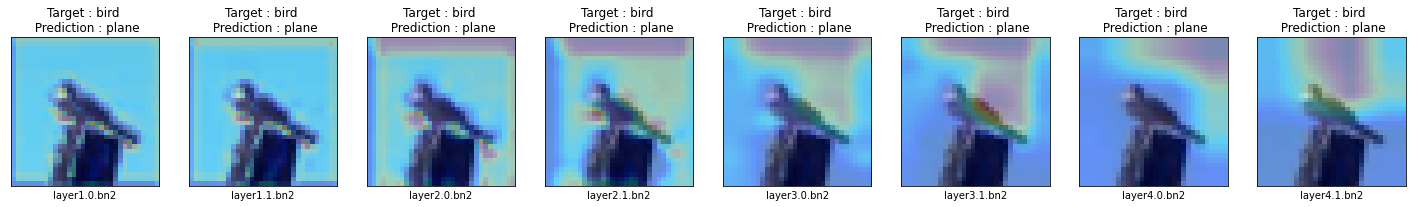

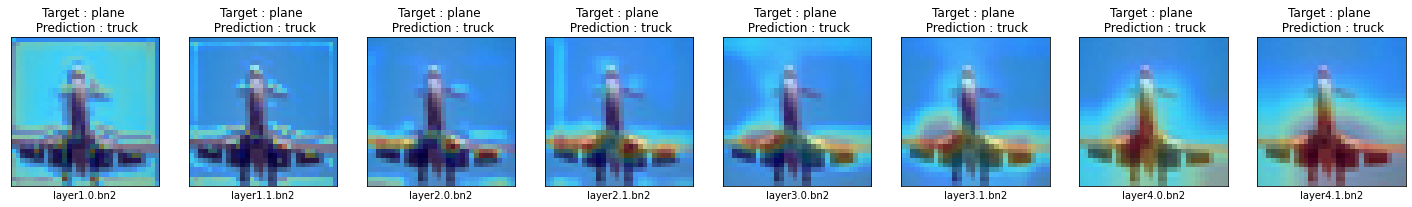

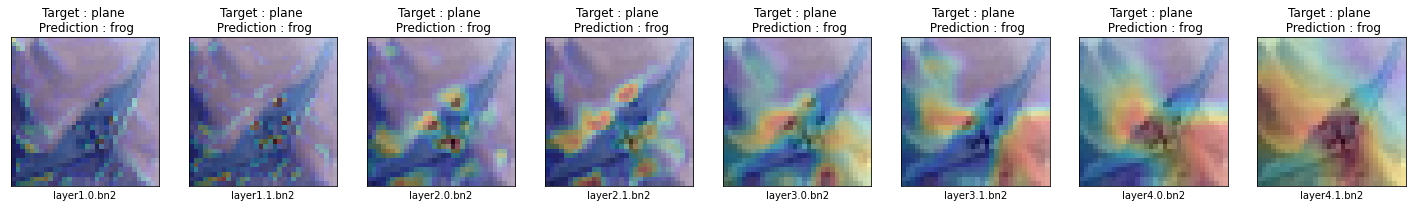

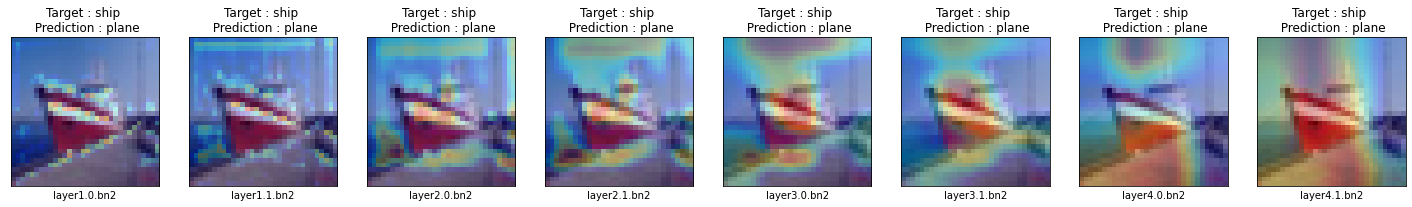

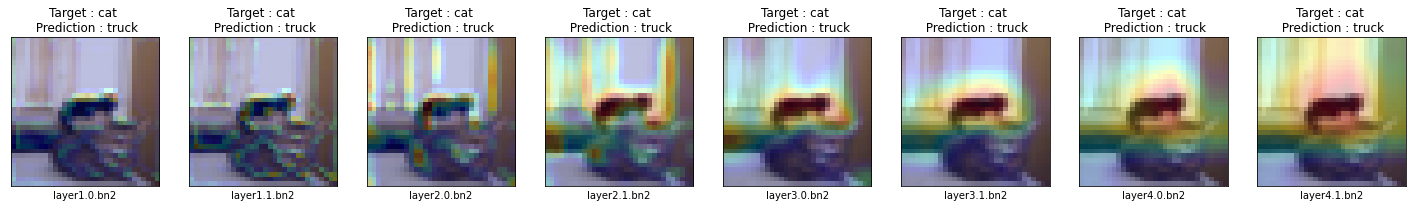

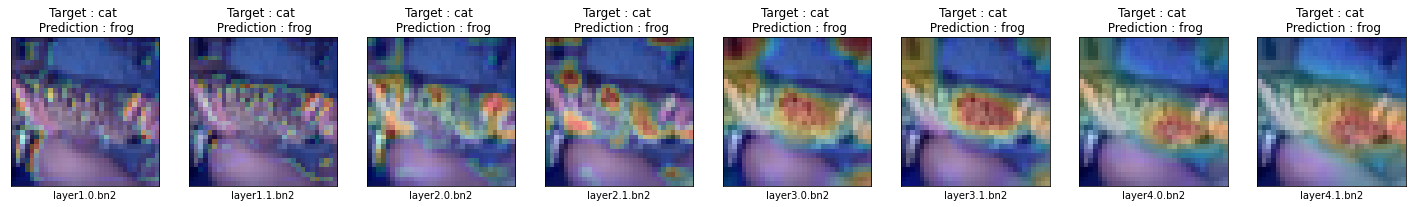

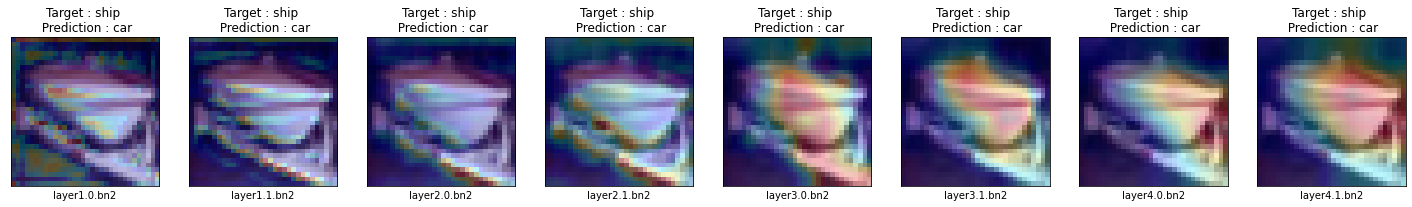

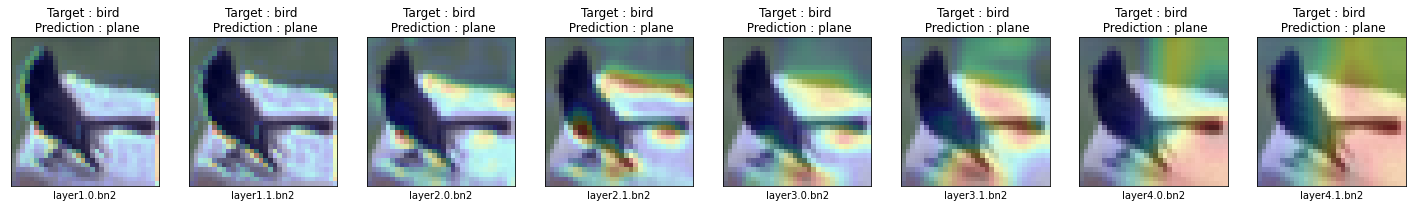

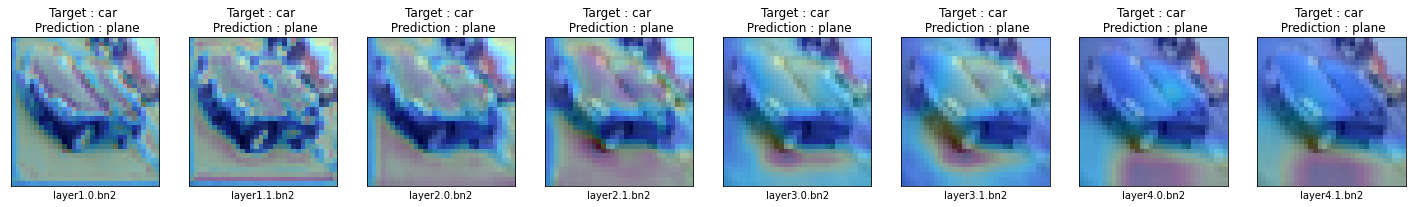

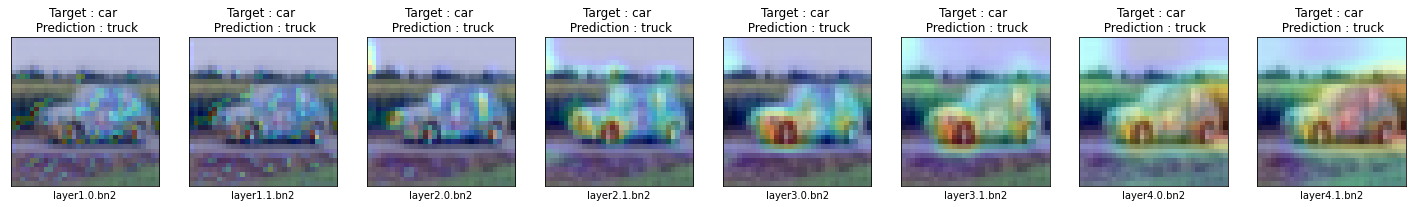

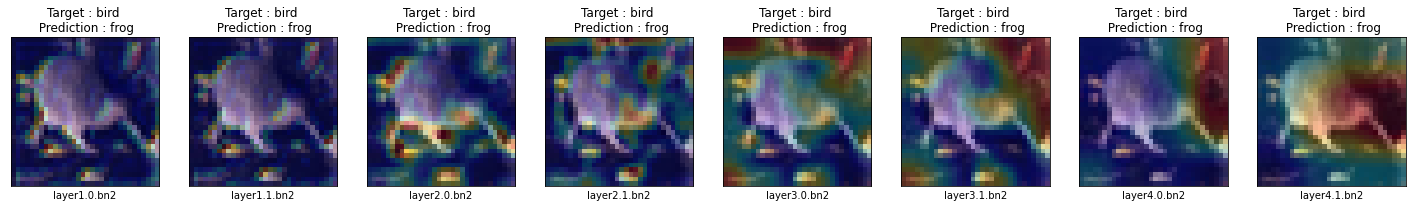

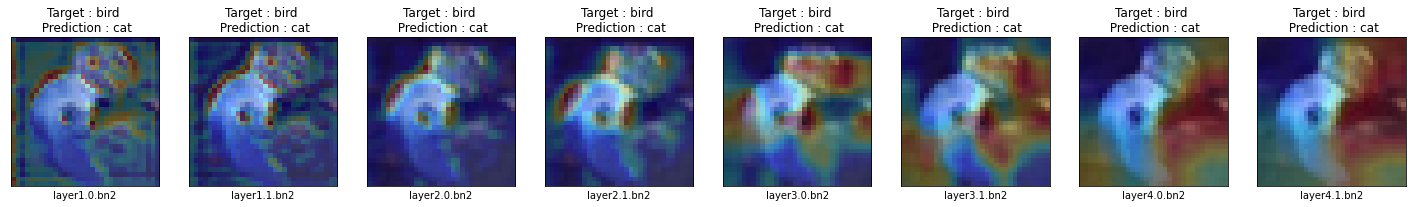

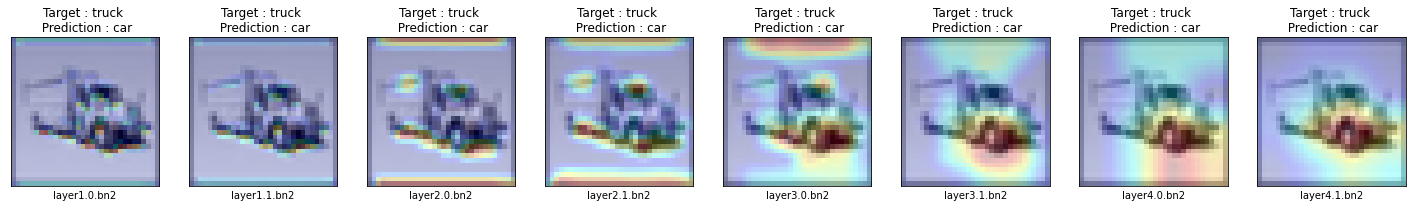

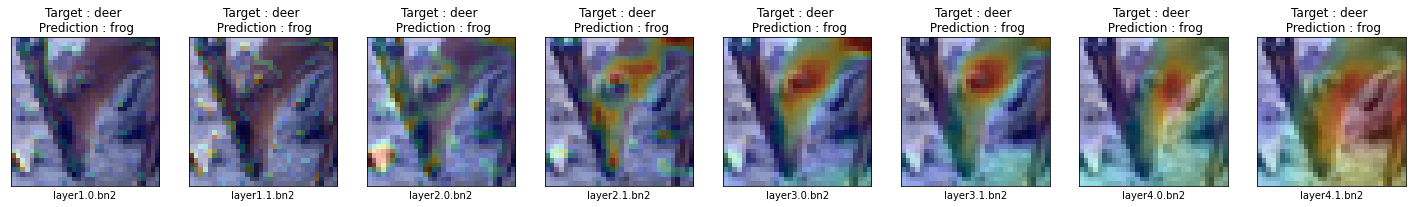

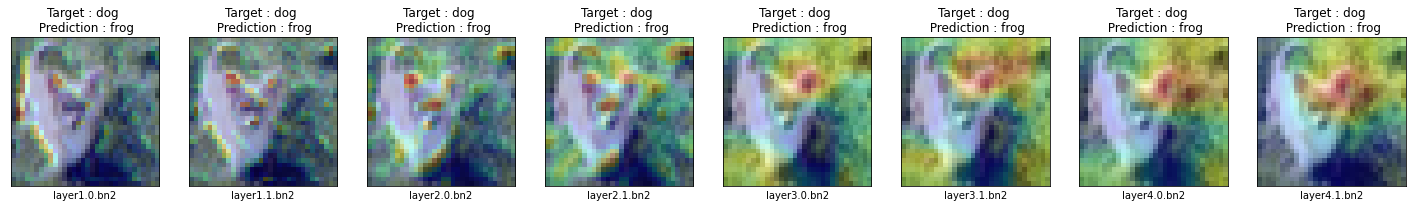

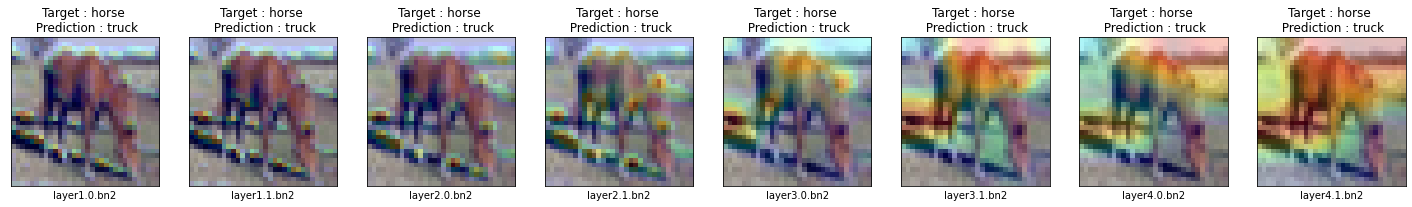

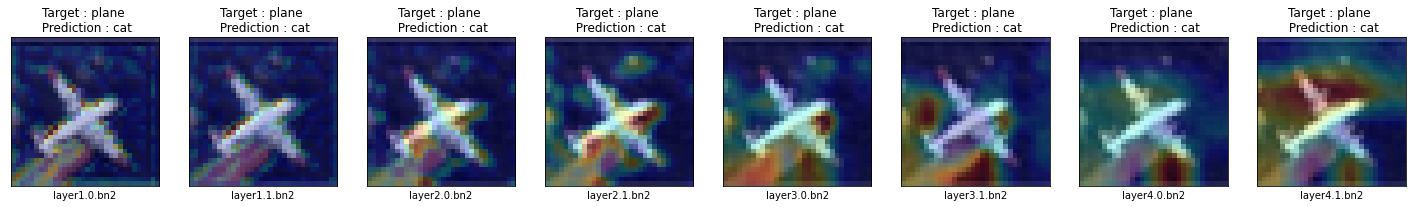

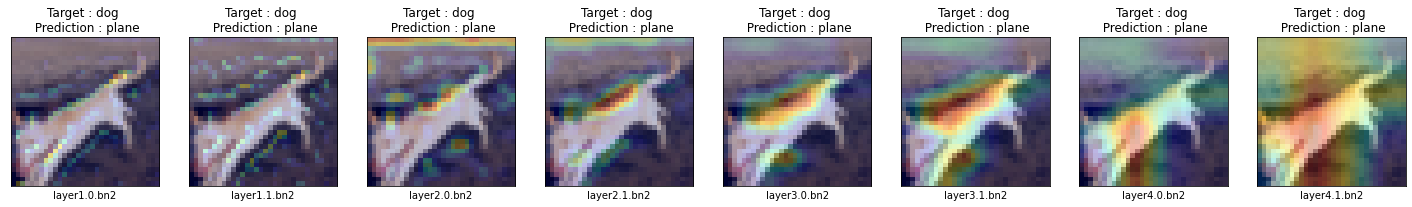

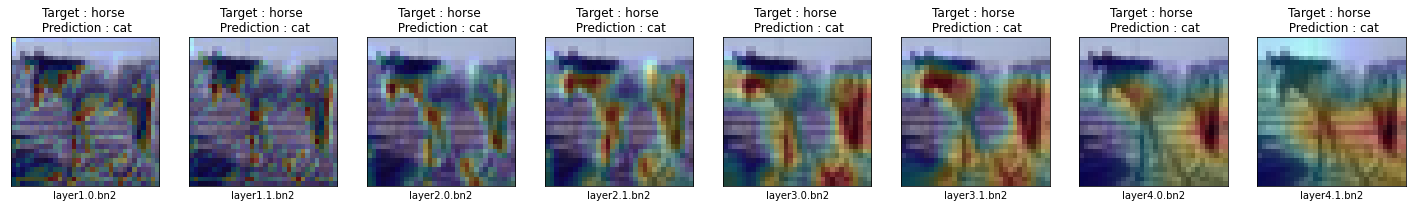

In [0]:
for idx, sample in enumerate(mis_classified_images):
  image = sample['data']
  one_hot_label = sample['prediction']
  target = sample['target']

  overlays = grad_cam.get_overlays(image, one_hot_label, target)
  grad_cam.display_heatmaps(overlays, one_hot_label, target)

In [0]:
experiment = Experiment(name=f'default', dataset_name='cifar10')

CUDA status: True
Files already downloaded and verified
Files already downloaded and verified



Learning rate search finished. See the graph with {finder_name}.plot()


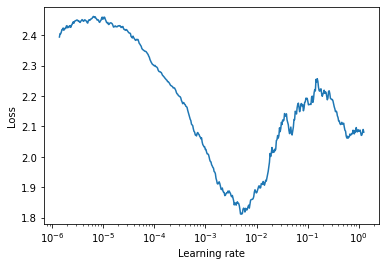

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(experiment.model.parameters(), lr=1e-6, momentum=0.9)

lr_finder = LRFinder(experiment.model, optimizer, criterion, device="cuda")
lr_finder.range_test(experiment.data_manager.train_loader, start_lr=1e-6, end_lr=1.4, num_iter=500, step_mode='exp')
lr_finder.plot(log_lr=True) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# Result
| Metric | Value |
| - | - |
| _Best train accuracy_| **95.12** |
| _Best test accuracy_| **91.61** |
| _Best epoch number_| **49** |
| _Parameter count_ | **11,173,962** |